In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
from itertools import permutations
from functools import partial, reduce
import networkx as nx

import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumProgram, QuantumCircuit
import Qconfig

from re import match
import itertools as it
from functools import reduce
from tools.vizualization import plot_state
from tools.qi import *
from tools.pauli import pauli_group
import tools.tomography as tomo

In [26]:
X0 = np.array([[0.5, 0.5], [0.5, 0.5]])
X1 = np.array([[0.5, -0.5], [-0.5, 0.5]])
Y0 = np.array([[0.5, -0.5j], [0.5j, 0.5]])
Y1 = np.array([[0.5, 0.5j], [-0.5j, 0.5]])
Z0 = np.array([[1, 0], [0, 0]])
Z1 = np.array([[0, 0], [0, 1]])

pauli_basis = {'X': [X0, X1], 'Y': [Y0, Y1], 'Z': [Z0, Z1]}

In [3]:
def process_tomo_data(Q_program, name, meas_qubits, basis=None):
    if basis is None:
        basis = pauli_basis
    labels = tomo.process_tomography_labels(name, meas_qubits)
    counts = [tomo.marginal_counts(Q_program.get_counts(circ), meas_qubits) for circ in labels]
    meas_basis = counts_basis(len(meas_qubits), basis)
    prep_basis = counts_basis(len(meas_qubits), basis)
    ret = [ {'prep_basis': i, 'meas_basis': j} 
           for i in prep_basis for j in meas_basis]
    for i in range(len(counts)):
        ret[i]['counts'] = counts[i]
    return ret

In [5]:
def state_linear_inv(qp, name, meas_qubits):
    if isinstance(meas_qubits, int):
        meas_qubits = [meas_qubits]
    state_dat = state_tomo_data(qp, name, meas_qubits)
    ks = tomo.__counts_keys(len(meas_qubits))
    state_cts = np.array([dat['counts'][k] for dat in state_dat for k in ks])
    state_ops = [dat['meas_basis'][k] for dat in state_dat for k in ks]
    return tomo_linear_inv(state_cts, state_ops)

def process_linear_inv(qp, name, meas_qubits):
    if isinstance(meas_qubits, int):
        meas_qubits = [meas_qubits]
    proc_dat = process_tomo_data(qp, name, meas_qubits)
    ks = tomo.__counts_keys(len(meas_qubits))
    proc_cts = np.array([dat['counts'][k] for dat in proc_dat for k in ks])
    proc_ops = [np.kron(dat['prep_basis'][k].T, dat['meas_basis'][k]) for dat in proc_dat for k in ks]
    return tomo_linear_inv(proc_cts, proc_ops, trace=2**len(meas_qubits))

In [14]:
state_data = tomo.state_tomography_data(qp, 'x', [0])

In [19]:
cts = []
ops = []
[dat['counts'].values() for dat in state_data])

array([dict_values([4893, 5107]), dict_values([4979, 5021]),
       dict_values([0, 10000])], dtype=object)

In [20]:
def __state_least_sq_fit(state_data, weights=None, beta=0.5):
    ks = state_data[0]['counts'].keys()
    
    # Get counts and shots
    ns = np.array([dat['counts'][k] for dat in state_dat for k in ks])
    shots = np.array([dat['shots'] for dat in state_dat for k in ks])
    
    # convert to freqs
    freqs = (ns + beta) / (shots + 2 * beta)
    
    # Use standard least squares fitting weights
    if weights is None:
        weights = np.sqrt(shots / (freqs * (1 - freqs)))
    
    # Get measurement basis ops
    ops = [dat['meas_basis'][k] for dat in state_dat for k in ks]
    
    return tomo_linear_inv(freqs, ops, weights, trace=1)

In [6]:
def reconstruct_state(state_data=None, method='wizard'):
    """
    Returns the reconstructed density matrix.
    """
    m = len(meas_qubits)
    counts = np.array([__none_to_zero(Q_program.get_counts(c).get(s))
                        for c in tomo_circuits
                        for s in tomo_outcome_strings(meas_qubits, nq)])
    if method == 'leastsq_wizard':
        return fit_state(counts / shots, nqubit_basis(m), normalize_flag=True, wizard_flag=True)
    elif method == 'least_sq':
        return fit_state(counts / shots, nqubit_basis(m), normalize_flag=True, wizard_flag=False)
    else:
        print("error: unknown reconstruction method")


NameError: name 'pauli_basis' is not defined

In [95]:
tomo.process_tomography_labels('id', [0])

['id_pX0_mX0',
 'id_pX0_mY0',
 'id_pX0_mZ0',
 'id_pY0_mX0',
 'id_pY0_mY0',
 'id_pY0_mZ0',
 'id_pZ0_mX0',
 'id_pZ0_mY0',
 'id_pZ0_mZ0']

In [68]:
state_dat = state_tomo_data(qp, 'id', [0])
ks = tomo.__counts_keys(1)
state_cts = np.array([dat['counts'][k] for dat in state_dat for k in ks])
state_ops = [dat['meas_basis'][k] for dat in state_dat for k in ks]
beta = 0.5
state_fs = (state_cts + beta) / (10000 + 2 * beta)
state_ws = np.sqrt(10000 / (state_fs * (1-state_fs)))

In [67]:
print(chop(tomo_linear_inv(state_cts / 10000, state_ops),1e-5))
print(chop(tomo_linear_inv(state_fs, state_ops, weights=state_ws),1e-2))
print(chop(tomo_linear_inv(state_cts, state_ops),1e-5))

[[ 1.0000+0.j      0.0026+0.0012j]
 [ 0.0026-0.0012j  0.0000+0.j    ]]
[[ 0.99995+0.j  0.00000+0.j]
 [ 0.00000+0.j  0.00000+0.j]]
[[ 1.0000+0.j      0.0026+0.0012j]
 [ 0.0026-0.0012j  0.0000+0.j    ]]


In [90]:
proc_dat = process_tomo_data(qp, 'z', [0])
ks = tomo.__counts_keys(1)
proc_cts = np.array([dat['counts'][k] for dat in proc_dat for k in ks])
proc_ops = [np.kron(np.conj(dat['prep_basis'][k]), dat['meas_basis'][k]) for dat in proc_dat for k in ks]
beta = 0.5
proc_fs = (proc_cts + beta) / (10000 + 2 * beta)
proc_ws = np.sqrt(10000 / (proc_fs * (1-proc_fs)))

In [91]:
choi1 = chop(tomo_linear_inv(proc_cts / 10000, proc_ops, trace=2),1e-5)
choi2 = chop(tomo_linear_inv(proc_fs, proc_ops, weights=proc_ws, trace=2),1e-4)
choi3 = chop(tomo_linear_inv(proc_cts, proc_ops, trace=2),1e-5)

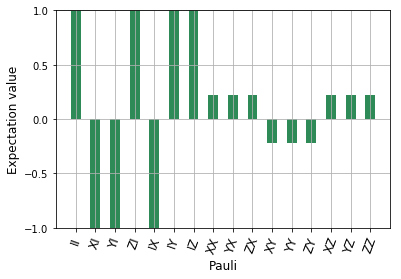

In [92]:
plot_state(choi2, method='paulivec')

In [4]:
qp = QuantumProgram()
qp.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
q1 = qp.create_quantum_registers("q1", 1)
c1 = qp.create_classical_registers("c1", 1)

# quantum circuit to make X, Y, Z gates 
gi = qp.create_circuit("id", [q1], [c1])
gx = qp.create_circuit("x", [q1], [c1])
gx.x(q1[0])
gy = qp.create_circuit("y", [q1], [c1])
gy.y(q1[0])

c1s = ['id', 'x', 'y']
for c in c1s:
    ls = tomo.build_state_tomography_circuits(qp, c, [0], q1, c1)
    #lp = tomo.build_process_tomography_circuits(qp, c, 0, q1, c1)
    qp.compile(ls, backend='local_qasm_cpp_simulator', shots=1000)
qp.run()

>> quantum_registers created: q1 1
>> classical_registers created: c1 1
>> created state tomography circuits for "id"
>> created state tomography circuits for "x"
>> created state tomography circuits for "y"
running on backend: local_qasm_cpp_simulator


{'result': 'all done', 'status': 'COMPLETED'}

In [7]:
datx = tomo.state_tomography_data(qp, 'x', [0])
datid = tomo.state_tomography_data(qp, 'id', [0])
daty = tomo.state_tomography_data(qp, 'y', [0])

In [8]:
tomo.fit_state(datid, method='leastsq')

array([[  9.99500500e-01 -4.93639214e-25j,
          3.99600400e-03 -5.99400599e-03j],
       [  3.99600400e-03 +5.99400599e-03j,
          4.99500500e-04 +4.93639214e-25j]])

In [10]:
tomo.fit_state(datid, method='wizard')

array([[  9.99500500e-01+0.j        ,   3.99600400e-03-0.00599401j],
       [  3.99600400e-03+0.00599401j,   4.99500500e-04+0.j        ]])